In [1]:
# Импорт библиотек

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [2]:
# Инициализация сети
class Net(nn.Module):                             # Объявляем класс нейронной сети
   def __init__(self):
       super(Net, self).__init__()
       self.layer = torch.nn.Linear(1, 1)         # Создаём линейный слой
   def forward(self, x):                          # Прямое распространение (forward pass) модели
       x = self.layer(x)
       return x
net = Net()

# Фиксирование 'рандома'
# np.random.seed(52)
# torch.manual_seed(52)

x = np.random.rand(100)
y = np.sin(x) * np.power(x,3) + 3*x + np.random.rand(100)*0.8
x = torch.from_numpy(x.reshape(-1,1)).float()
y = torch.from_numpy(y.reshape(-1,1)).float()


# Создаем пустые списки для сохранения весов и смещений
weights_history = []
bias_history = []
loss_values = []

x_SGD = []
y_SDG = []


optimizer = torch.optim.SGD(net.parameters(), lr=0.2)     # Создание оптимизатора
loss_func = torch.nn.MSELoss()                            # Создаем функцию потерь MSE

   # Используем переменную 'x' - в качестве входных данных
   # Используем переменную 'y' - в качестве выходных данных
inputs = Variable(x)
outputs = Variable(y)

for i in range(250):
   prediction = net(x)               # Получение прогнозов модели на основе входных данных
   loss = loss_func(prediction, y)  # Вычисление функции потерь на основе прогнозов модели и ожидаемых выходных данных

   optimizer.zero_grad()  # Обнуляем градиенты, чтобы избежать накопления градиентов из предыдущих итераций
   loss.backward()        # Обратное распространение: вычисление градиентов функции потерь по параметрам модели
   optimizer.step()       # Шаг оптимизации: обновление параметров модели в соответствии с градиентами

   weights_history.append(net.layer.weight.data.clone())            # Сохраняем веса и смещения в списки
   bias_history.append(net.layer.bias.data.clone())
   loss_values.append(loss.item())

print('Градиент для weight - {}'.format(net.layer.weight.grad[-1]))  # Вывод градиента для весов слоя
print('Градиент для bias - {}'.format(net.layer.bias.grad[-1]))      # Вывод градиента для смещения слоя


Градиент для weight - tensor([-0.0003])
Градиент для bias - 0.000174693763256073


In [3]:
for param in net.parameters():
     print(param)
     print()

Parameter containing:
tensor([[3.7270]], requires_grad=True)

Parameter containing:
tensor([0.1863], requires_grad=True)



###  Для градиентного спуска

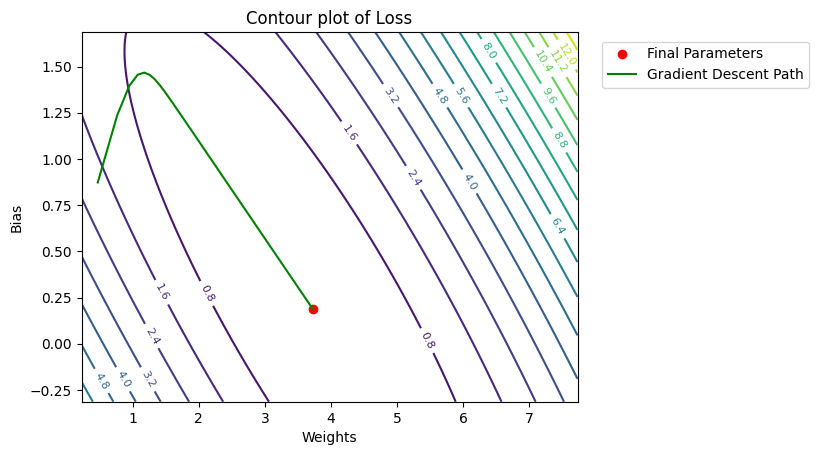

In [4]:
# Получаем обученные параметры модели
final_weights = weights_history[-1].numpy()
final_bias = bias_history[-1].numpy()

# Создаем сетку точек в пространстве параметров
num_points = 100

# lr = 0.2
w_range = np.linspace(final_weights - 3.5, final_weights + 4, num_points)
b_range = np.linspace(final_bias - 0.5, final_bias + 1.5, num_points)

# lr = 0.5
#w_range = np.linspace(final_weights - 3.5, final_weights + 2, num_points)
#b_range = np.linspace(final_bias - 0.5, final_bias + 2, num_points)

# lr = 0.02
#w_range = np.linspace(final_weights - 3.5, final_weights + 2, num_points)
#b_range = np.linspace(final_bias - 0.5, final_bias + 0.5, num_points)

W, B = np.meshgrid(w_range, b_range)

# Вычисляем потери для каждой точки на сетке
loss_grid = np.zeros((num_points, num_points))
for i in range(num_points):
    for j in range(num_points):
        # Получаем веса и смещение для текущей точки на сетке
        w = W[i, j]
        b = B[i, j]
        # Вычисляем предсказания и потери для текущих параметров
        predictions = np.dot(x.numpy(), w) + b
        loss = np.mean((predictions - y.numpy()) ** 2)
        loss_grid[i, j] = loss

# Строим контурный график уровней потерь
plt.figure()
contour = plt.contour(W, B, loss_grid, levels=20)
plt.clabel(contour, inline=True, fontsize=8)
plt.xlabel('Weights')
plt.ylabel('Bias')
plt.title('Contour plot of Loss')
plt.scatter(final_weights, final_bias, color='red', label='Final Parameters')  # Отображаем финальные параметры модели

# Отображаем путь градиентного спуска
plt.plot([w.numpy()[0] for w in weights_history], [b.numpy()[0] for b in bias_history], color='green', label='Gradient Descent Path')

plt.legend(loc=(1.05, 0.85))
plt.show()


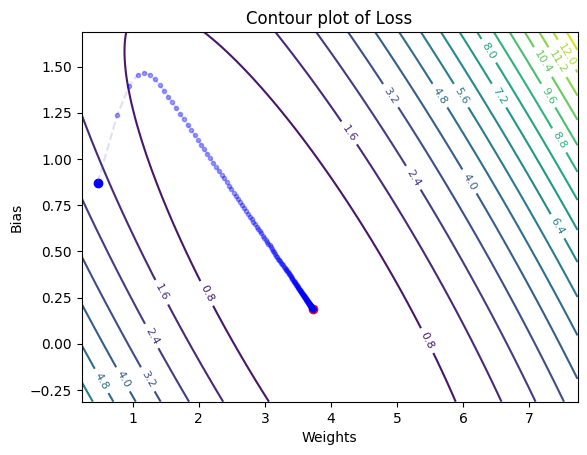

In [5]:
# Создаем новый график
fig, ax = plt.subplots()

# Определяем контурный график уровней потерь
contour = ax.contour(W, B, loss_grid, levels=20)
ax.clabel(contour, inline=True, fontsize=8)
ax.set_xlabel('Weights')
ax.set_ylabel('Bias')
ax.set_title('Contour plot of Loss')

# Отображаем финальные параметры модели
final_point, = ax.plot([], [], 'ro', label='Final Parameters')

# Отображаем начальные параметры модели
start_point, = ax.plot(weights_history[0], bias_history[0], 'bo', label='Start Parameters')

# Функция для анимации
def update(frame):
    if frame == 0:
        return start_point,
    else:
        ax.plot(weights_history[frame], bias_history[frame], 'bo', alpha=0.35, markersize=3)
        return start_point,

# Создаем анимацию
ani = FuncAnimation(fig, update, frames=len(weights_history), blit=True)

# Отмечаем точку минимума красным цветом
min_loss_index = np.argmin(loss_values)
min_loss_weights = weights_history[min_loss_index]
min_loss_bias = bias_history[min_loss_index]
ax.scatter(min_loss_weights, min_loss_bias, color='red', label='Minimum Loss')

# Отображаем путь градиентного спуска с пунктиром
ax.plot([w.numpy()[0] for w in weights_history], [b.numpy()[0] for b in bias_history], color='slateblue', linestyle='--', label='Gradient Descent Path', alpha=0.2)

# Отображаем анимацию в виде HTML-видео
from IPython.display import HTML
HTML(ani.to_html5_video())

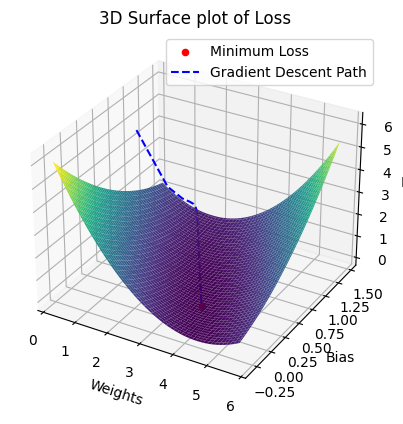

In [6]:
# Создаем новый трехмерный график
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Создаем сетку точек в пространстве параметров
num_points = 100
w_range = np.linspace(final_weights - 3.5, final_weights + 2, num_points)
b_range = np.linspace(final_bias - 0.5, final_bias + 1.25, num_points)
W, B = np.meshgrid(w_range, b_range)

# Вычисляем потери для каждой точки на сетке
loss_grid = np.zeros((num_points, num_points))
for i in range(num_points):
    for j in range(num_points):
        # Получаем веса и смещение для текущей точки на сетке
        w = W[i, j]
        b = B[i, j]
        # Вычисляем предсказания и потери для текущих параметров
        predictions = np.dot(x.numpy(), w) + b
        loss = np.mean((predictions - y.numpy()) ** 2)
        loss_grid[i, j] = loss

# Отображаем трехмерный график поверхности
surf = ax.plot_surface(W, B, loss_grid, cmap='viridis')
ax.set_xlabel('Weights')
ax.set_ylabel('Bias')
ax.set_zlabel('Loss')
ax.set_title('3D Surface plot of Loss')

# Отмечаем точку минимума красным цветом
min_loss_index = np.argmin(loss_values)
min_loss_weights = weights_history[min_loss_index]
min_loss_bias = bias_history[min_loss_index]
ax.scatter(min_loss_weights, min_loss_bias, loss_values[min_loss_index], color='red', label='Minimum Loss')

# Отображаем траекторию градиентного спуска
weights_history_reshaped = np.array(weights_history).reshape(-1, 1)
bias_history_reshaped = np.array(bias_history).reshape(-1, 1)
loss_values_reshaped = np.array(loss_values).reshape(-1, 1)
ax.plot(weights_history_reshaped, bias_history_reshaped, loss_values_reshaped, color='blue', linestyle='--', label='Gradient Descent Path')

# Добавляем легенду
ax.legend()

plt.show()


###  Для стохастического  спуска

In [ ]:
# Инициализация сети
class Net(nn.Module):                             # Объявляем класс нейронной сети
   def __init__(self):
       super(Net, self).__init__()
       self.layer = torch.nn.Linear(1, 1)         # Создаём линейный слой
   def forward(self, x):                          # Прямое распространение (forward pass) модели
       x = self.layer(x)
       return x
net = Net()

# Фиксирование 'рандома'
# np.random.seed(52)
# torch.manual_seed(52)

x = np.random.rand(100)
y = np.sin(x) * np.power(x,3) + 3*x + np.random.rand(100)*0.8
x = torch.from_numpy(x.reshape(-1,1)).float()
y = torch.from_numpy(y.reshape(-1,1)).float()


# Создаем пустые списки для сохранения весов и смещений
weights_history = []
bias_history = []
loss_values = []

x_SGD = []
y_SDG = []


optimizer = torch.optim.SGD(net.parameters(), lr=0.2)     # Создание оптимизатора
loss_func = torch.nn.MSELoss()                            # Создаем функцию потерь MSE

   # Используем переменную 'x' - в качестве входных данных
   # Используем переменную 'y' - в качестве выходных данных
inputs = Variable(x)
outputs = Variable(y)

for i in range(250):

   # Выбираем индекс для градиентного спуска
   ind = np.random.randint(0, 100)
   x_SGD = x[ind]
   y_SGD = y[ind]

   prediction = net(x_SGD)               # Получение прогнозов модели на основе входных данных
   loss = loss_func(prediction, y_SGD)  # Вычисление функции потерь на основе прогнозов модели и ожидаемых выходных данных

   optimizer.zero_grad()  # Обнуляем градиенты, чтобы избежать накопления градиентов из предыдущих итераций
   loss.backward()        # Обратное распространение: вычисление градиентов функции потерь по параметрам модели
   optimizer.step()       # Шаг оптимизации: обновление параметров модели в соответствии с градиентами

   weights_history.append(net.layer.weight.data.clone())            # Сохраняем веса и смещения в списки
   bias_history.append(net.layer.bias.data.clone())
   loss_values.append(loss.item())

print('Градиент для weight - {}'.format(net.layer.weight.grad[-1]))  # Вывод градиента для весов слоя
print('Градиент для bias - {}'.format(net.layer.bias.grad[-1]))      # Вывод градиента для смещения слоя


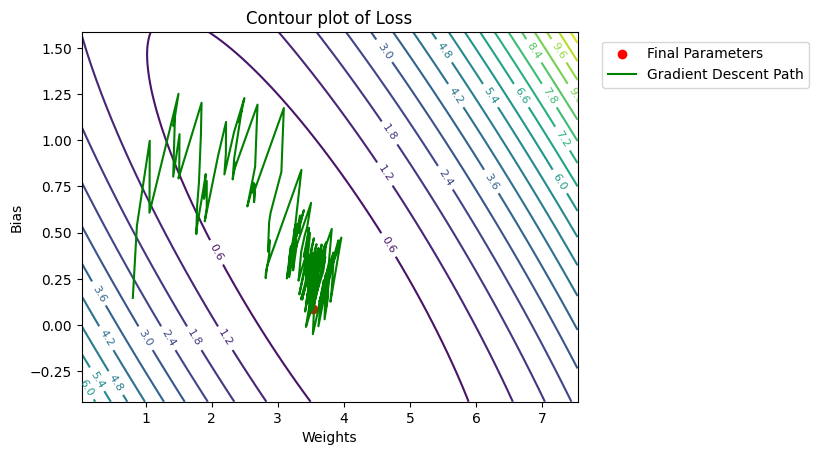

In [ ]:
# Получаем обученные параметры модели
final_weights = weights_history[-1].numpy()
final_bias = bias_history[-1].numpy()

# Создаем сетку точек в пространстве параметров
num_points = 100

# lr = 0.2
w_range = np.linspace(final_weights - 3.5, final_weights + 4, num_points)
b_range = np.linspace(final_bias - 0.5, final_bias + 1.5, num_points)

# lr = 0.5
#w_range = np.linspace(final_weights - 3.5, final_weights + 2, num_points)
#b_range = np.linspace(final_bias - 0.5, final_bias + 2, num_points)

# lr = 0.02
#w_range = np.linspace(final_weights - 3.5, final_weights + 2, num_points)
#b_range = np.linspace(final_bias - 0.5, final_bias + 0.5, num_points)

W, B = np.meshgrid(w_range, b_range)

# Вычисляем потери для каждой точки на сетке
loss_grid = np.zeros((num_points, num_points))
for i in range(num_points):
    for j in range(num_points):
        # Получаем веса и смещение для текущей точки на сетке
        w = W[i, j]
        b = B[i, j]
        # Вычисляем предсказания и потери для текущих параметров
        predictions = np.dot(x.numpy(), w) + b
        loss = np.mean((predictions - y.numpy()) ** 2)
        loss_grid[i, j] = loss

# Строим контурный график уровней потерь
plt.figure()
contour = plt.contour(W, B, loss_grid, levels=20)
plt.clabel(contour, inline=True, fontsize=8)
plt.xlabel('Weights')
plt.ylabel('Bias')
plt.title('Contour plot of Loss')
plt.scatter(final_weights, final_bias, color='red', label='Final Parameters')  # Отображаем финальные параметры модели

# Отображаем путь градиентного спуска
plt.plot([w.numpy()[0] for w in weights_history], [b.numpy()[0] for b in bias_history], color='green', label='Gradient Descent Path')

plt.legend(loc=(1.05, 0.85))
plt.show()


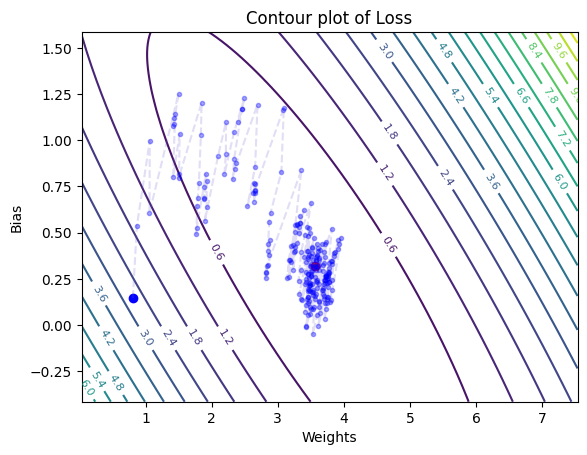

In [ ]:
# Создаем новый график
fig, ax = plt.subplots()

# Определяем контурный график уровней потерь
contour = ax.contour(W, B, loss_grid, levels=20)
ax.clabel(contour, inline=True, fontsize=8)
ax.set_xlabel('Weights')
ax.set_ylabel('Bias')
ax.set_title('Contour plot of Loss')

# Отображаем финальные параметры модели
final_point, = ax.plot([], [], 'ro', label='Final Parameters')

# Отображаем начальные параметры модели
start_point, = ax.plot(weights_history[0], bias_history[0], 'bo', label='Start Parameters')

# Функция для анимации
def update(frame):
    if frame == 0:
        return start_point,
    else:
        ax.plot(weights_history[frame], bias_history[frame], 'bo', alpha=0.35, markersize=3)
        return start_point,

# Создаем анимацию
ani = FuncAnimation(fig, update, frames=len(weights_history), blit=True)

# Отмечаем точку минимума красным цветом
min_loss_index = np.argmin(loss_values)
min_loss_weights = weights_history[min_loss_index]
min_loss_bias = bias_history[min_loss_index]
ax.scatter(min_loss_weights, min_loss_bias, color='red', label='Minimum Loss')

# Отображаем путь градиентного спуска с пунктиром
ax.plot([w.numpy()[0] for w in weights_history], [b.numpy()[0] for b in bias_history], color='slateblue', linestyle='--', label='Gradient Descent Path', alpha=0.2)

# Отображаем анимацию в виде HTML-видео
from IPython.display import HTML
HTML(ani.to_html5_video())

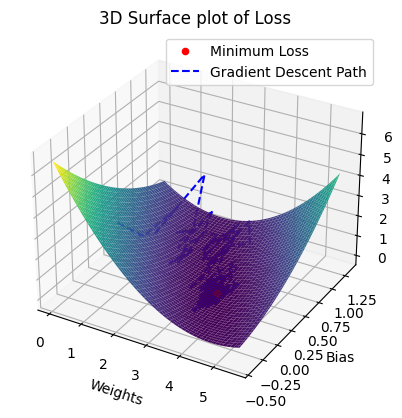

In [ ]:
# Создаем новый трехмерный график
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Создаем сетку точек в пространстве параметров
num_points = 100
w_range = np.linspace(final_weights - 3.5, final_weights + 2, num_points)
b_range = np.linspace(final_bias - 0.5, final_bias + 1.25, num_points)
W, B = np.meshgrid(w_range, b_range)

# Вычисляем потери для каждой точки на сетке
loss_grid = np.zeros((num_points, num_points))
for i in range(num_points):
    for j in range(num_points):
        # Получаем веса и смещение для текущей точки на сетке
        w = W[i, j]
        b = B[i, j]
        # Вычисляем предсказания и потери для текущих параметров
        predictions = np.dot(x.numpy(), w) + b
        loss = np.mean((predictions - y.numpy()) ** 2)
        loss_grid[i, j] = loss

# Отображаем трехмерный график поверхности
surf = ax.plot_surface(W, B, loss_grid, cmap='viridis')
ax.set_xlabel('Weights')
ax.set_ylabel('Bias')
ax.set_zlabel('Loss')
ax.set_title('3D Surface plot of Loss')

# Отмечаем точку минимума красным цветом
min_loss_index = np.argmin(loss_values)
min_loss_weights = weights_history[min_loss_index]
min_loss_bias = bias_history[min_loss_index]
ax.scatter(min_loss_weights, min_loss_bias, loss_values[min_loss_index], color='red', label='Minimum Loss')

# Отображаем траекторию градиентного спуска
weights_history_reshaped = np.array(weights_history).reshape(-1, 1)
bias_history_reshaped = np.array(bias_history).reshape(-1, 1)
loss_values_reshaped = np.array(loss_values).reshape(-1, 1)
ax.plot(weights_history_reshaped, bias_history_reshaped, loss_values_reshaped, color='blue', linestyle='--', label='Gradient Descent Path')

# Добавляем легенду
ax.legend()

plt.show()


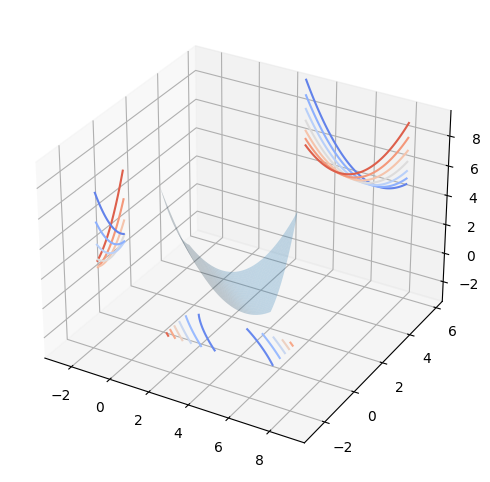

In [ ]:
# Создаем новый трехмерный график
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection='3d')

# Отображаем поверхность и контуры с проекциями
ax.plot_surface(W, B, loss_grid, rstride=4, cstride=4, alpha=0.25)
cset = ax.contour(W, B, loss_grid, zdir='z', offset=-np.pi, cmap='coolwarm')
cset = ax.contour(W, B, loss_grid, zdir='x', offset=-np.pi, cmap='coolwarm')
cset = ax.contour(W, B, loss_grid, zdir='y', offset=3*np.pi, cmap='coolwarm')

# Устанавливаем пределы для каждой оси
ax.set_xlim3d(-np.pi, 3*np.pi)
ax.set_ylim3d(-np.pi, 2*np.pi)
ax.set_zlim3d(-np.pi, 3*np.pi)

plt.show()

In [ ]:
# Диапазон значений для весов
min_weight = np.min(weights_history)
max_weight = np.max(weights_history)

# Диапазон значений для смещений
min_bias = np.min(bias_history)
max_bias = np.max(bias_history)

# Диапазон значений для потерь
min_loss = np.min(loss_values)
max_loss = np.max(loss_values)

print("Диапазон значений для весов:", min_weight, "-", max_weight)
print("Диапазон значений для смещений:", min_bias, "-", max_bias)
print("Диапазон значений для потерь:", min_loss, "-", max_loss)


Диапазон значений для весов: 0.8080685 - 3.9610524
Диапазон значений для смещений: -0.04918949 - 1.251415
Диапазон значений для потерь: 2.4978498913696967e-07 - 2.6096417903900146


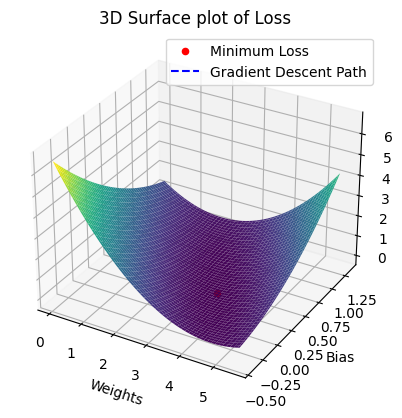

In [ ]:
# Создаем новый трехмерный график
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Создаем сетку точек в пространстве параметров
num_points = 100
w_range = np.linspace(final_weights - 3.5, final_weights + 2, num_points)
b_range = np.linspace(final_bias - 0.5, final_bias + 1.25, num_points)
W, B = np.meshgrid(w_range, b_range)

# Вычисляем потери для каждой точки на сетке
loss_grid = np.zeros((num_points, num_points))
for i in range(num_points):
    for j in range(num_points):
        # Получаем веса и смещение для текущей точки на сетке
        w = W[i, j]
        b = B[i, j]
        # Вычисляем предсказания и потери для текущих параметров
        predictions = np.dot(x.numpy(), w) + b
        loss = np.mean((predictions - y.numpy()) ** 2)
        loss_grid[i, j] = loss

# Отображаем трехмерный график поверхности
surf = ax.plot_surface(W, B, loss_grid, cmap='viridis')
ax.set_xlabel('Weights')
ax.set_ylabel('Bias')
ax.set_zlabel('Loss')
ax.set_title('3D Surface plot of Loss')

# Отмечаем точку минимума красным цветом
min_loss_index = np.argmin(loss_values)
min_loss_weights = weights_history[min_loss_index]
min_loss_bias = bias_history[min_loss_index]
ax.scatter(min_loss_weights, min_loss_bias, loss_values[min_loss_index], color='red', label='Minimum Loss')

# Инициализируем линию градиентного спуска
line, = ax.plot([], [], [], color='blue', linestyle='--', label='Gradient Descent Path')

# Обновление функции для анимации
def update(num, data, line):
    line.set_data(data[:2, :num])
    line.set_3d_properties(data[2, :num])

# Создание анимации
data = np.array([weights_history_reshaped.flatten(), bias_history_reshaped.flatten(), loss_values_reshaped.flatten()])
ani = FuncAnimation(fig, update, frames=range(len(weights_history_reshaped)), fargs=(data, line), interval=50, repeat=False)

# Добавляем легенду
ax.legend()

# Отображаем анимацию в виде HTML-видео
from IPython.display import HTML
HTML(ani.to_html5_video())

In [ ]:
# Создаем трехмерную поверхность
fig = go.Figure()

# Добавляем трехмерную поверхность
fig.add_trace(go.Surface(z=loss_grid, x=W, y=B, colorscale='Viridis', opacity=0.8))

# Находим индекс минимального значения потерь
min_loss_index = np.argmin(loss_values)
min_loss_weight = weights_history[min_loss_index]
min_loss_bias = bias_history[min_loss_index]
min_loss_value = loss_values[min_loss_index]

# Добавляем красную точку минимального значения потерь
fig.add_trace(go.Scatter3d(x=[min_loss_weight], y=[min_loss_bias], z=[min_loss_value],
                           mode='markers', marker=dict(size=5, color='red'), name='Minimum Loss'))

# Настройка макета графика
fig.update_layout(title='3D Surface plot of Loss with Minimum Loss Point',
                  scene=dict(
                      xaxis_title='Weights',
                      yaxis_title='Bias',
                      zaxis_title='Loss',
                      aspectmode='manual',
                      aspectratio=dict(x=1, y=1, z=0.5)  # Задаем соотношение сторон осей
                  ))

# Отображаем интерактивный график
fig.show()
